In [20]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m
import cantera as ct

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
from src.data import H2_combustion1
from src.edmd import TruncEDMD
from src.kernels import RBFKernel
from src.training_edmd import GD_edmd_training
from src.visualizations import  dynamicscombust,gridsearchnorm,traininglandscapenorm,OOS_system_normalize
from matplotlib.legend_handler import HandlerTuple

In [51]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Define intiial conditions and time interval then plot the result of the original system

(459, 2)
(459, 2)


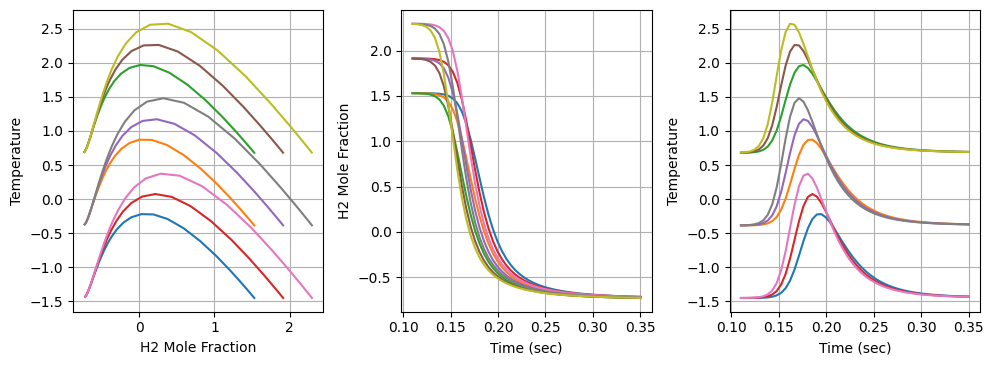

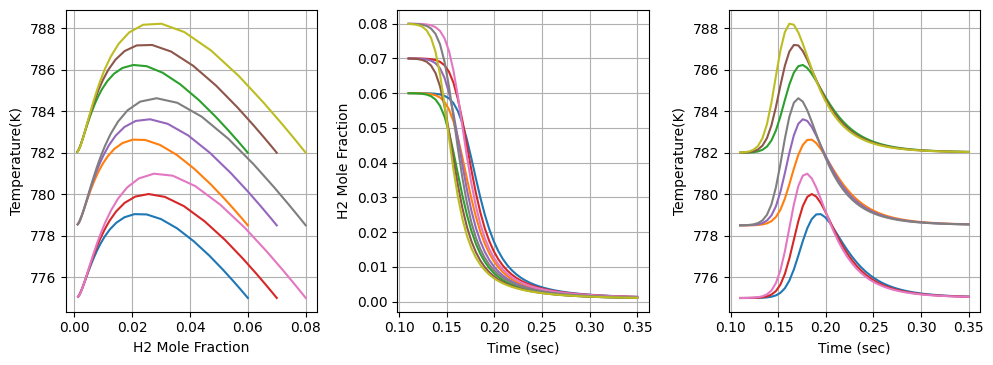

In [55]:
dynamic_system="non_steady_state_H2_single"
f, ax = plt.subplots(1, 3, figsize=(10, 3.75))
f1, ax1 = plt.subplots(1, 3, figsize=(10, 3.75))
timesteps=300
factor=4
t_end=0.35#0.0006
t_begin=0.11

initial_conditions= np.array(np.meshgrid(np.linspace(0.06,0.08,3), np.linspace(775, 782,3))).T.reshape(-1, 2)

x,y,initial_conditions_norm,original_norm,original,t_eval_frac=dynamicscombust(H2_combustion1,initial_conditions,t_end,timesteps,factor,t_begin)
timesteps=len(t_eval_frac)


for ic, condition in enumerate(initial_conditions_norm):
    
    ax[0].plot(original_norm[ic*(timesteps):ic*(timesteps)+(timesteps), 0],original_norm[ic*(timesteps):ic*(timesteps)+(timesteps), 1],)
    
    ax[1].plot(t_eval_frac,original_norm[ic*(timesteps):ic*(timesteps)+(timesteps), 0])
    ax[2].plot(t_eval_frac,original_norm[ic*(timesteps):ic*(timesteps)+(timesteps), 1])
    ax1[0].plot(original[ic*(timesteps):ic*(timesteps)+(timesteps), 0],original[ic*(timesteps):ic*(timesteps)+(timesteps), 1],)
    ax1[1].plot(t_eval_frac,original[ic*(timesteps):ic*(timesteps)+(timesteps), 0])
    ax1[2].plot(t_eval_frac,original[ic*(timesteps):ic*(timesteps)+(timesteps), 1])



ax[0].grid()
ax[0].set_xlabel("H2 Mole Fraction")
ax[0].set_ylabel("Temperature")


ax[1].grid()
ax[1].set_xlabel("Time (sec)")
ax[1].set_ylabel("H2 Mole Fraction")

ax[2].grid()
ax[2].set_xlabel("Time (sec)")
ax[2].set_ylabel("Temperature")

ax1[0].grid()
ax1[0].set_xlabel("H2 Mole Fraction")
ax1[0].set_ylabel("Temperature(K)")
#ax[0].set_ylim(775,790)

ax1[1].grid()
ax1[1].set_xlabel("Time (sec)")
ax1[1].set_ylabel("H2 Mole Fraction")

ax1[2].grid()
ax1[2].set_xlabel("Time (sec)")
ax1[2].set_ylabel("Temperature(K)")



f.tight_layout()
f1.tight_layout()



Perform Grid search

In [57]:

initial_conditions= np.array(np.meshgrid(np.linspace(0.06,0.08,3), np.linspace(775, 782,3))).T.reshape(-1, 2)
initial_conditions_sample=np.array([[0.065,779],[0.077,781],[0.074,775]])
method = TruncEDMD()
parameters =np.array([0.1,0.5,1.0,])#np.array([0.1,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0])
truncs=np.array([1,5,10,15])#np.array([1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,110,120,130,140,150,160,170,180])

factors=np.array([2,4])
t_begin=0.11

t_end=0.25#0.0006
timesteps=160
kernel = RBFKernel
index=0

lossperstep,OOSlossperstep,optim=gridsearchnorm(factors,truncs,parameters,initial_conditions,
                                                initial_conditions_sample,timesteps,t_end,method,
                                                kernel,H2_combustion1,t_begin)




(396, 2)
(396, 2)
(198, 2)
(198, 2)
(396, 2)
(396, 2)
(198, 2)
(198, 2)
(396, 2)
(396, 2)
(198, 2)
(198, 2)


Plot Results of Grid Search

(array([2], dtype=int64), array([3], dtype=int64))


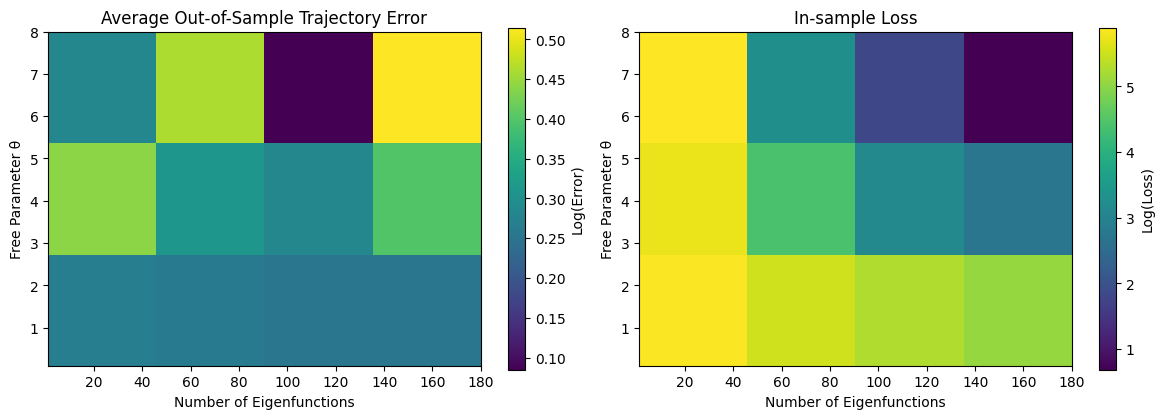

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns of subplots


im1 = ax[0].imshow(np.log(OOSlossperstep),extent=[1,180,0.1,8],aspect=17.5,origin="lower")
cbar1 = fig.colorbar(im1, ax=ax[0],shrink=0.6,)  # Colorbar for the first image
cbar1.set_label("Log(Error)")
ax[0].set_xlabel("Number of Eigenfunctions")
ax[0].set_ylabel("Free Parameter θ")

ax[0].set_title("Average Out-of-Sample Trajectory Error")  


im2 = ax[1].imshow(np.log(lossperstep),extent=[1,180,0.1,8],aspect=17.5,origin="lower")
cbar2 = fig.colorbar(im2, ax=ax[1],shrink=0.6)  

ax[1].set_xlabel("Number of Eigenfunctions")
ax[1].set_ylabel("Free Parameter θ")
ax[1].set_title("In-sample Loss")  

cbar2.set_label("Log(Loss)")


plt.tight_layout()

plt.tight_layout()
min=np.where(optim == np.nanmin(optim))
print(min)
# Show the plot
plt.show()



Explore the training landscape

In [61]:
#x_next_DMD=edmd.trajectory_visualization_DMD(x,y,LinearKernel())
initial_conditions = np.array(np.meshgrid(np.linspace(0.06,0.08,3), np.linspace(775, 782,3))).T.reshape(-1, 2)
t_end=0.25#0.0006
timesteps=160
trunc=10
method = TruncEDMD()
factor=4
parameters = np.linspace(0.05, 100, num=10)
func=H2_combustion1
t_begin=0.11
kernel= RBFKernel
#f, ax = plt.subplots()

losstrain,min_loss=traininglandscapenorm(initial_conditions,t_end,timesteps,factor,trunc,method,
                          kernel,parameters,func,t_begin)


Plot the Training Landscape

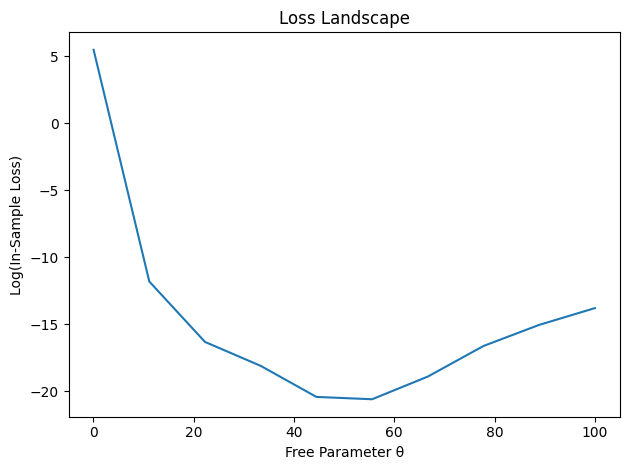

In [63]:
f, ax = plt.subplots()
ax.plot( parameters[0:200], np.log(losstrain[0:200]), label='Training Loss')



ax.set_xlabel('Free Parameter θ')
ax.set_ylabel('Log(In-Sample Loss)')
ax.set_title("Loss Landscape") 

f.tight_layout()


Perform Training using optimized paramters

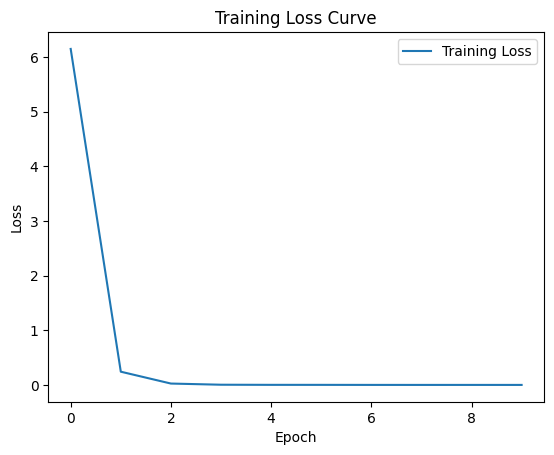

[Parameter containing:
tensor(7.8483, requires_grad=True)]


In [65]:
method = TruncEDMD()
parameter = torch.tensor(1.0, requires_grad=True)
kernel = RBFKernel([parameter])
initial_conditions = np.array(np.meshgrid(np.linspace(0.06,0.08,3), np.linspace(775, 782,3))).T.reshape(-1, 2)
t_end=0.25#0.0006
timesteps=160
trunc=10
factor=4
t_begin=0.11
func= H2_combustion1
num_epochs=10

x,y,initial_conditions_norm,original_norm,original,t_eval_frac=dynamicscombust(func,initial_conditions,
                                                                                t_end,timesteps,factor,t_begin)

train_loss, min_param = GD_edmd_training(num_epochs,1, x.T, y.T, kernel, method,trunc, 
     lr=1e-1,full=True, penalty=True)

fig, ax = plt.subplots()
plt.plot( np.array(range(0,num_epochs)), np.array(train_loss), label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()
print(list(kernel.parameters()))


visualize training 

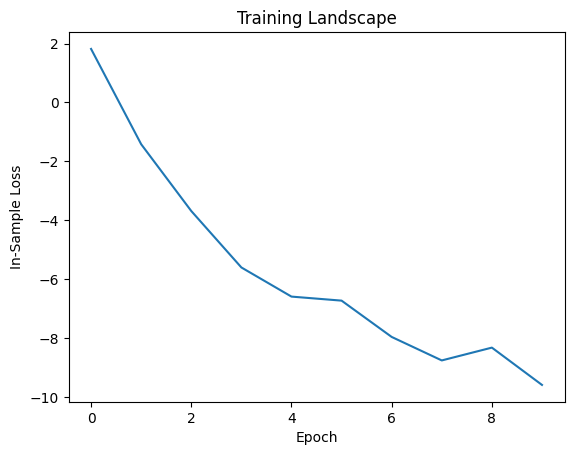

[Parameter containing:
tensor(7.8483, requires_grad=True)]


In [66]:
fig, ax = plt.subplots()
plt.plot( np.array(range(0,num_epochs)), np.array(np.log(train_loss[0:])), label='Training Loss')

ax.set_xlabel('Epoch')
ax.set_ylabel('In-Sample Loss')
ax.set_title("Training Landscape") 

plt.show()
print(list(kernel.parameters()))


Plot and report the in-sample and out of sample loss for the best paramter combination

loss tensor(0.9001, dtype=torch.float64, grad_fn=<AddBackward0>)


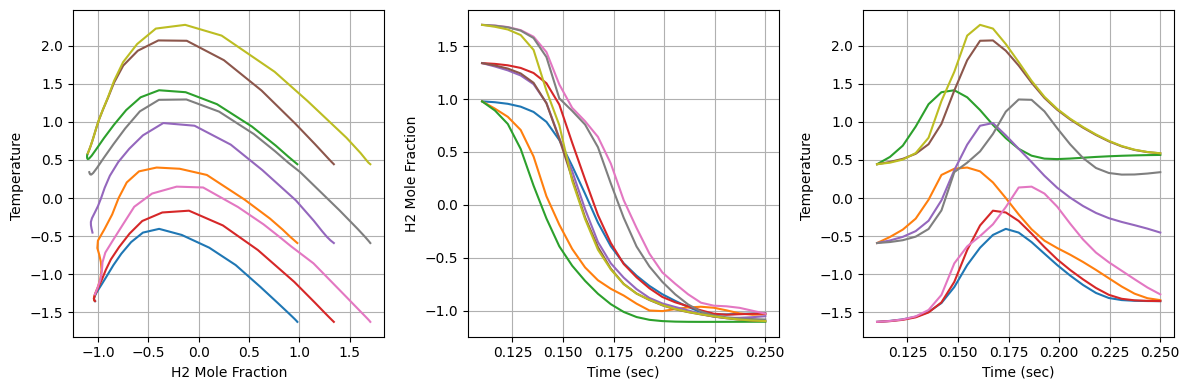

In [67]:
#in sample #########
initial_conditions = np.array(np.meshgrid(np.linspace(0.06,0.08,3), np.linspace(775, 782,3))).T.reshape(-1, 2)
t_end=0.25#0.0006
timesteps=160

dt=t_end/timesteps
t_eval=np.linspace(0, t_end, timesteps)
trunc=60
factor=4
method = TruncEDMD()
t_begin=0.11

parameter=torch.tensor(0.5,requires_grad=True) #33.2791   
kernel = RBFKernel([parameter])

x,y,initial_conditions_norm,original_norm,original,t_eval_frac=dynamicscombust(func,
                                                    initial_conditions,t_end,timesteps,factor,t_begin)
Kernel_results=method.edmd_computations(x.T,y.T,kernel,trunc)
method.preloss_computation_full()
loss = method.loss_full(kernel, x.T, y.T, penalty=True)
f, ax = plt.subplots(1, 3, figsize=(12, 4))

for ic,condition in enumerate(initial_conditions_norm):

    condition=np.array([condition],ndmin=2)
    Fx=method.single_tradjectory(t_eval_frac,condition.T,x.T,y.T,kernel,Kernel_results) 
   
    ax[0].plot(Fx[:,0],Fx[:,1])
    ax[0].set_xlabel("H2 Mole Fraction")
    ax[0].set_ylabel("Temperature ")
    ax[0].grid()
    ax[1].plot(t_eval_frac,Fx[:,0],)
    ax[1].set_xlabel("Time (sec)")
    ax[1].set_ylabel("H2 Mole Fraction")
    ax[1].grid()
    ax[2].plot(t_eval_frac,Fx[:,1],)
    ax[2].set_xlabel("Time (sec)")
    ax[2].set_ylabel("Temperature ")
    ax[2].grid()
    
    #x1=Fx[(len(t_eval_frac)//4), 0]
    #y1=Fx[(len(t_eval_frac)//4), 1]
    #dx=Fx[len(t_eval_frac)//4+1, 0]-Fx[len(t_eval_frac)//4, 0]
    #dy=Fx[len(t_eval_frac)//4+1, 1]-Fx[len(t_eval_frac)//4, 1]
    #ax[0].arrow(x1,y1,dx,dy,width=0.02,color="black")
    f.tight_layout()
print("loss",loss)


L2_norm 0.8211453453979675


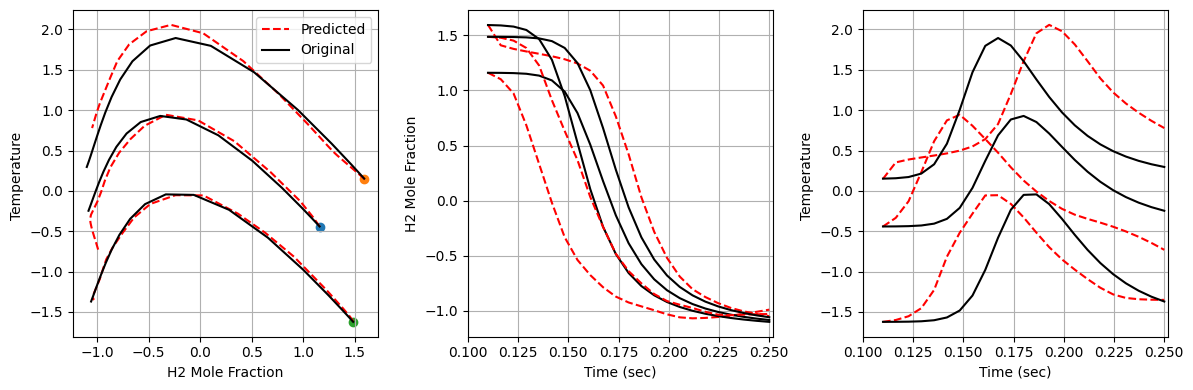

In [68]:
#out of sample specification#################################################################   
f, ax = plt.subplots(1, 3, figsize=(12, 4))


initial_conditions_sample=np.array([[0.065,779],[0.077,781],[0.074,775]])


x,y,initial_conditions_norm,original_norm,original,t_eval_frac=dynamicscombust(func,
                                                initial_conditions,t_end,timesteps,factor,t_begin)
Kernel_results=method.edmd_computations(x.T,y.T,kernel,trunc)
method.preloss_computation_full()


t_eval_sample = t_eval_frac

sumloss=0
for ic,condition in enumerate(initial_conditions_sample):
     
        t_eval=np.linspace(0, t_end, timesteps) #normal trajectory here
        dynamics_norm,initial_condition_norm_sample=OOS_system_normalize(t_eval,condition,original,func)
        int_begin=int(t_begin//(t_end/timesteps)) #change here!!!!!
        dynamics_norm=dynamics_norm[int_begin::factor]

        initial_condition_norm_sample=np.array([initial_condition_norm_sample],ndmin=2)
        predicted=method.single_tradjectory(t_eval_frac,initial_condition_norm_sample.T,x.T,y.T,kernel,Kernel_results) 
        sumloss = sumloss+np.sqrt(np.sum(np.square((abs(predicted-dynamics_norm))))/len(t_eval_frac))
       
        ax[0].plot(predicted[:,0],predicted[:,1],0.1,c="red",linestyle='--', label="Predicted" )   
        ax[0].plot(dynamics_norm[:,0],dynamics_norm[:,1],0.1,c="black", label="Original" )  
        ax[0].scatter(initial_condition_norm_sample[:,0],initial_condition_norm_sample[:,1]) 
        ax[0].set_xlabel("H2 Mole Fraction")
        ax[0].set_ylabel("Temperature ")
        ax[1].set_xlim([0.1,0.252])
        ax[2].set_xlim([0.1,0.252])
        ax[0].grid()
        ax[1].plot(t_eval_sample,predicted[:,0],0.1,c="red",linestyle='--', label="Predicted" )
        ax[2].plot(t_eval_sample,predicted[:,1],0.1,c="red",linestyle='--', label="Predicted" )
        ax[1].set_xlabel("Time (sec)")
        ax[1].set_ylabel("H2 Mole Fraction")
        ax[1].grid()
        ax[2].set_xlabel("Time (sec)")
        ax[2].set_ylabel("Temperature ")
        ax[2].grid()
      
        ax[1].plot(t_eval_sample,dynamics_norm[:,0],0.1,c="black", label="Original" )  
        ax[2].plot(t_eval_sample,dynamics_norm[:,1],0.1,c="black", label="Original" ) 
        legend_without_duplicate_labels(ax[0])
l2=sumloss/len(initial_conditions_sample)          

f.tight_layout()
print("L2_norm",l2)     
   
